# Modulo5: Comparación Multipunto de la Frontera de Diversificación

Este notebook evalúa múltiples puntos relevantes de la frontera de diversificación y optimiza carteras para cada uno, usando el mismo pipeline del módulo de selección de activos.

In [1]:
import sys
from pathlib import Path
import importlib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Añadir src/ al path si es necesario
src_path = Path('..') / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Imports de módulos necesarios
datos = importlib.import_module('1datos')
diversificacion = importlib.import_module('2equiponderada_diversificacion')
multipunto = importlib.import_module('5analisis_multipunto')
seleccion = importlib.import_module('4seleccion_activos')

print('Librerías y módulos importados correctamente')

Librerías y módulos importados correctamente


## Cargar datos

Se cargan los retornos diarios desde el archivo de datos y se valida la dimensión del DataFrame.

In [3]:
ruta_csv = Path('..') / 'data' / 'prod_long_sharpe_u50_20260116_v5_train_dataset.csv'
if not ruta_csv.exists():
    raise FileNotFoundError(f"No se encontró el archivo de datos: {ruta_csv}")

retornos = datos.cargar_retornos(str(ruta_csv))

print(f"Dimensiones del DataFrame: {retornos.shape[0]} días, {retornos.shape[1]} activos")
print(retornos.head())

Datos cargados: 1760 días, 50 activos
Dimensiones del DataFrame: 1760 días, 50 activos
     asset1    asset2    asset3    asset4    asset5    asset6    asset7  \
0  0.014482  0.001804 -0.004049  0.011592  0.006422  0.005713 -0.001772   
1  0.001715 -0.002062 -0.009170 -0.006120  0.007793 -0.004029  0.008242   
2 -0.016415 -0.001549 -0.013395 -0.004101  0.003523 -0.001010 -0.002054   
3  0.003695  0.002580  0.013395 -0.004806  0.002809  0.003698  0.013568   
4 -0.000651  0.006421  0.008155  0.005491  0.003500  0.005689  0.003038   

     asset8    asset9   asset10  ...   asset41   asset42   asset43   asset44  \
0  0.004928  0.012250  0.001355  ...  0.013830  0.008159  0.005384  0.007865   
1 -0.007896 -0.003558  0.002705  ... -0.001637 -0.010346 -0.000632  0.007015   
2 -0.002127 -0.003468 -0.007455  ...  0.001309 -0.008244 -0.005705  0.004725   
3  0.000142  0.009862  0.004073  ...  0.019758  0.001654  0.004756  0.011492   
4  0.004778  0.005650  0.010111  ...  0.023143  0.003300 -0.00

## Simular frontera de diversificación

Se simula la frontera equiponderada y se visualizan los resultados de riesgo total y descomposición.


TABLA RESUMEN: FRONTERA DE DIVERSIFICACIÓN
  N |  Vol(%) |   ±Std |  Esp(%) |  Sis(%) |  Reduc
--------------------------------------------------------------------------------
  2 |   17.99 |   4.06 |   14.09 |   11.91 |    N/A
  3 |   16.43 |   3.01 |   11.74 |   11.89 |  8.67%
  4 |   15.69 |   2.89 |   10.30 |   12.17 |  4.55%
  5 |   14.52 |   2.21 |    8.89 |   11.68 |  7.47%
  6 |   14.43 |   2.04 |    8.38 |   11.92 |  0.58%
  7 |   13.84 |   1.74 |    7.62 |   11.69 |  4.07%
  8 |   14.05 |   1.64 |    7.23 |   12.16 | -1.46%
  9 |   13.86 |   1.60 |    6.87 |   12.14 |  1.36%
 10 |   13.33 |   1.40 |    6.49 |   11.73 |  3.76%
 12 |   13.04 |   1.38 |    5.83 |   11.75 |  2.20%
 15 |   12.69 |   1.13 |    5.19 |   11.63 |  2.71%
 20 |   12.67 |   0.82 |    4.51 |   11.87 |  0.13%
 25 |   12.58 |   0.62 |    4.09 |   11.92 |  0.69%
 30 |   12.45 |   0.55 |    3.71 |   11.90 |  1.03%
 40 |   12.21 |   0.35 |    3.20 |   11.79 |  1.96%
 50 |   12.18 |   0.00 |    2.87 |   11.83 

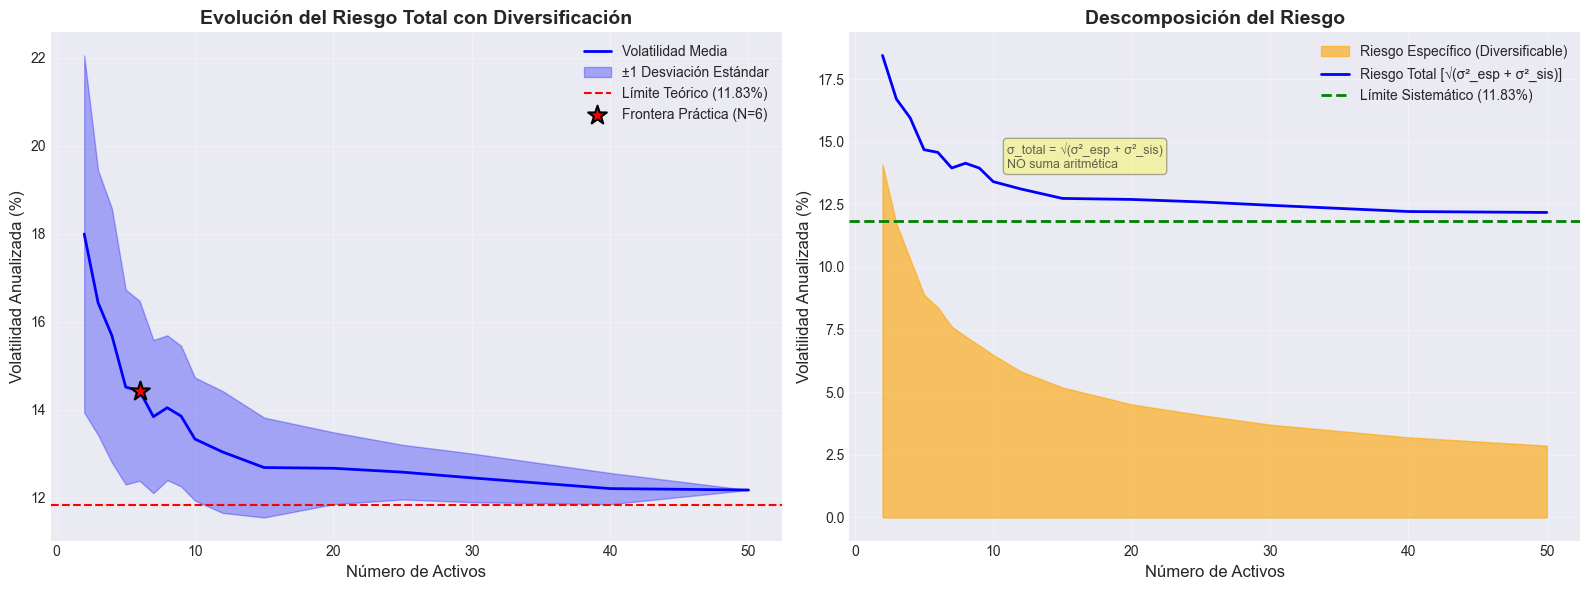

In [ ]:
df_frontera = diversificacion.simular_frontera_diversificacion(
    retornos,
    n_valores=None,
    n_simulaciones=100
)

print(df_frontera.head())

ruta_frontera = Path('outputs') / 'frontera_diversificacion_multipunto.png'
ruta_frontera.parent.mkdir(parents=True, exist_ok=True)
fig = diversificacion.visualizar_frontera_diversificacion(df_frontera, ruta_guardado=str(ruta_frontera))
plt.show()

## Detectar puntos de interés

Se detectan mínimos locales, puntos con reducción marginal baja y cambios de pendiente relevantes.

In [8]:
criterios = {
    'umbral_reduccion': 2.0,
    'umbral_cambio_pendiente': None
}

lista_n = multipunto.detectar_puntos_interes_frontera(df_frontera, criterios)
print(f"Puntos de interés detectados: {lista_n}")

# Explicación breve de relevancia para cada N
vol = df_frontera['volatilidad_media'].values
n_vals = df_frontera['n_activos'].astype(int).values
reduccion = df_frontera['reduccion_pct'].values
pendientes = np.diff(vol) / np.diff(n_vals)
cambios_pendiente = np.diff(pendientes) if len(pendientes) > 1 else np.array([])

umbral_reduccion = criterios['umbral_reduccion']
umbral_cambio = criterios['umbral_cambio_pendiente']
if umbral_cambio is None:
    umbral_cambio = np.std(cambios_pendiente) if len(cambios_pendiente) > 0 else 0.0

for n in lista_n:
    idx = np.where(n_vals == n)[0][0]
    razones = []
    if 0 < idx < len(vol) - 1 and vol[idx] < vol[idx - 1] and vol[idx] < vol[idx + 1]:
        razones.append('mínimo local de volatilidad')
    if not np.isnan(reduccion[idx]) and reduccion[idx] < umbral_reduccion:
        razones.append(f"reducción marginal < {umbral_reduccion}%")
    if len(cambios_pendiente) > 0 and 1 <= idx < len(n_vals) - 1:
        cambio_idx = idx - 1
        if 0 <= cambio_idx < len(cambios_pendiente) and abs(cambios_pendiente[cambio_idx]) > umbral_cambio:
            razones.append('cambio de pendiente significativo')
    if not razones:
        razones.append('punto de control')
    print(f"N={n}: {', '.join(razones)}")

Puntos de interés detectados: [3, 5, 6, 7, 8, 9, 20, 25, 30, 40, 50]
N=3: cambio de pendiente significativo
N=5: cambio de pendiente significativo
N=6: reducción marginal < 2.0%, cambio de pendiente significativo
N=7: mínimo local de volatilidad, cambio de pendiente significativo
N=8: reducción marginal < 2.0%
N=9: reducción marginal < 2.0%
N=20: reducción marginal < 2.0%
N=25: reducción marginal < 2.0%
N=30: reducción marginal < 2.0%
N=40: reducción marginal < 2.0%
N=50: reducción marginal < 2.0%


## Optimizar carteras para todos los puntos

Se ejecuta la optimización completa para cada N detectado.

In [9]:
resultados = multipunto.optimizar_multiples_n(
    retornos,
    lista_n=lista_n,
    rf_anual=0.02,
    peso_sharpe=0.7
)

Optimizando cartera con N=3...
Optimizando cartera con N=5...
Optimizando cartera con N=6...
Optimizando cartera con N=7...
Optimizando cartera con N=8...
Optimizando cartera con N=9...
Optimizando cartera con N=20...
Optimizando cartera con N=25...
Optimizando cartera con N=30...
Optimizando cartera con N=40...
Optimizando cartera con N=50...


## Consolidar y mostrar resultados

Se consolida la información de todas las carteras para comparar Sharpe, rentabilidad y volatilidad.

In [10]:
df_consolidado = multipunto.consolidar_resultados_multipunto(resultados)
print(df_consolidado)

mejor_n = int(df_consolidado.loc[0, 'n_activos'])
mejor_sharpe = df_consolidado.loc[0, 'sharpe_cartera']
print(f"Mejor Sharpe encontrado en N={mejor_n} con Sharpe={mejor_sharpe:.4f}")

    n_activos  sharpe_cartera  rentabilidad_anual  volatilidad_anual  peso_rf  \
0           3        1.073922            0.124704           0.097497      0.1   
1           5        1.046198            0.121041           0.096580      0.1   
2           6        0.921899            0.110165           0.097803      0.1   
3           7        0.921337            0.112041           0.099899      0.1   
4           8        0.855895            0.105464           0.099854      0.1   
5           9        0.847126            0.105213           0.100590      0.1   
6          20        0.703065            0.089683           0.099113      0.1   
7          25        0.550879            0.071986           0.094370      0.1   
8          30        0.502708            0.067855           0.095194      0.1   
9          40        0.326320            0.051553           0.096693      0.1   
10         50        0.041961            0.023954           0.094237      0.1   

    n_activos_con_peso  cor

## Visualización comparativa

Se comparan las carteras en un panel 2x2 con Sharpe, riesgo-retorno, rentabilidad vs volatilidad y peso en RF.

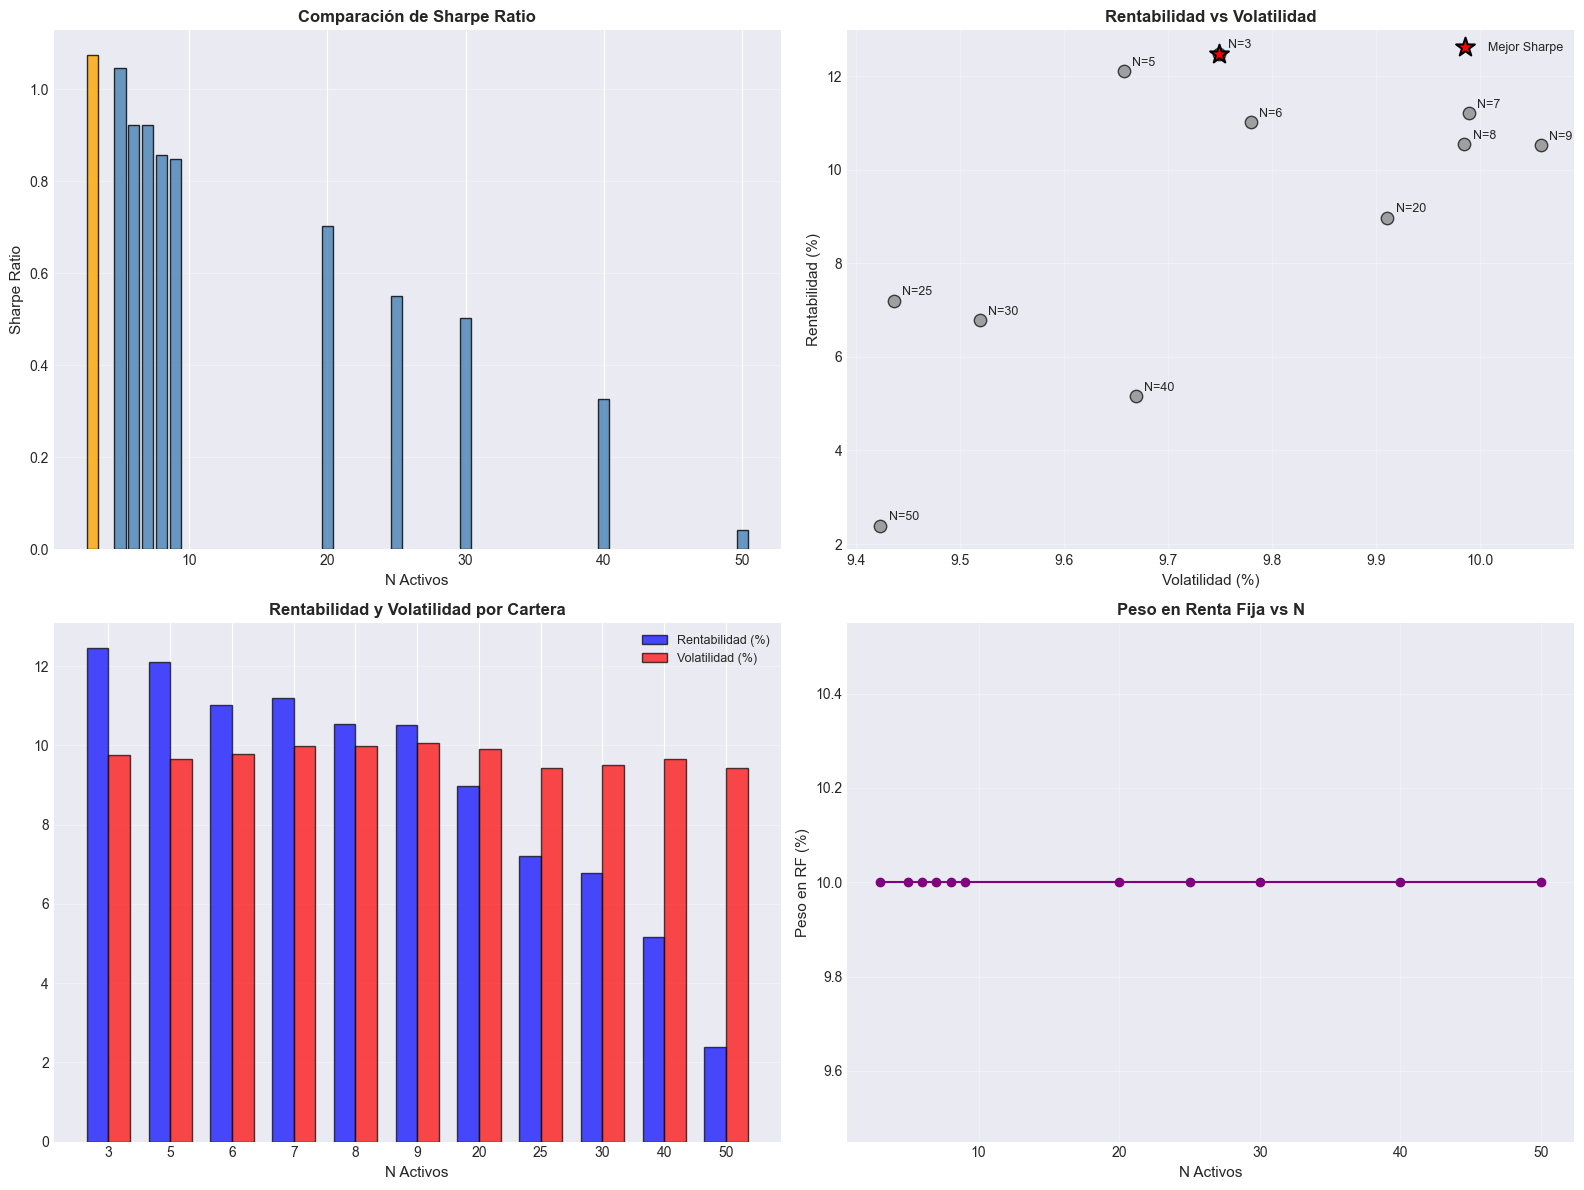

In [ ]:
ruta_comparacion = Path('outputs') / 'comparacion_multipunto'
fig = multipunto.visualizar_comparacion_multipunto(df_consolidado, resultados, ruta_guardado=str(ruta_comparacion))
plt.show()

## Heatmap de composición

Se muestra un heatmap con los pesos de los activos más utilizados en las carteras.

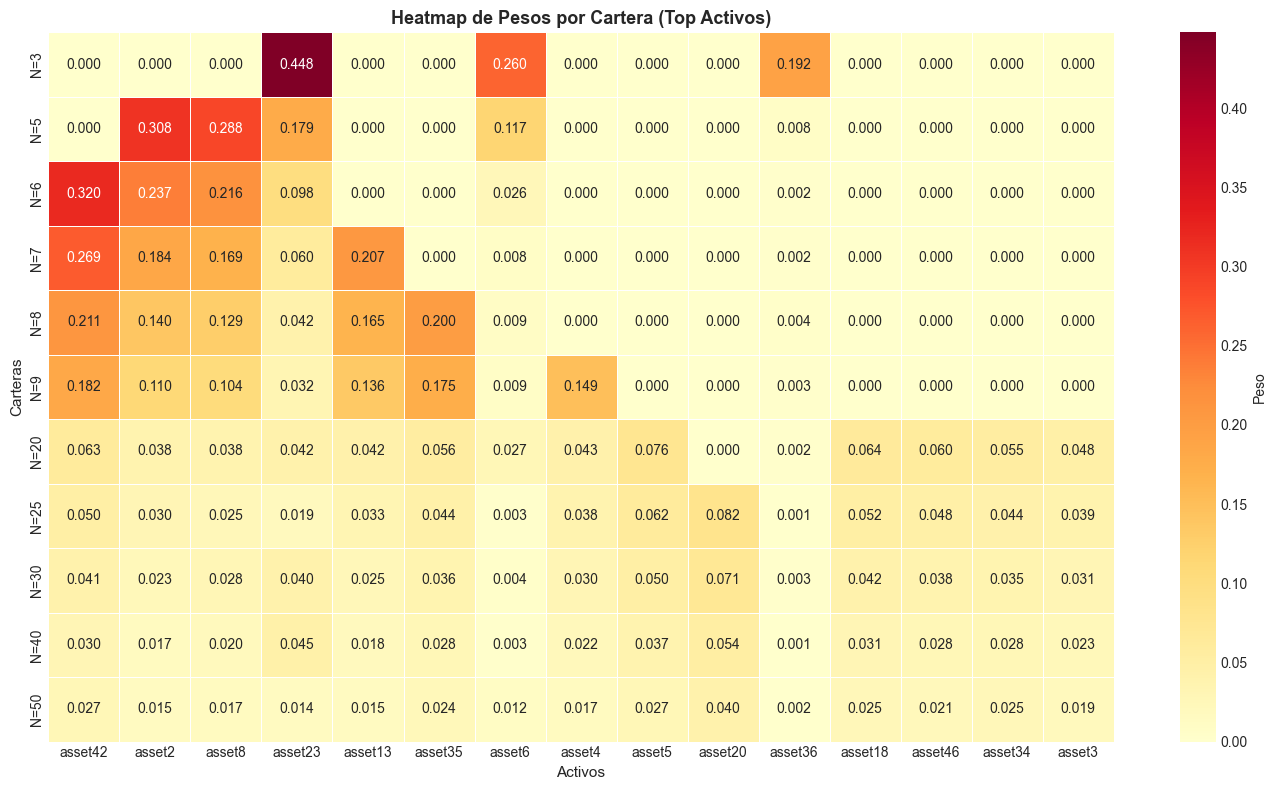

In [ ]:
ruta_heatmap = Path('outputs') / 'heatmap_pesos_multipunto'
fig = multipunto.generar_heatmap_pesos(resultados, top_activos=15, ruta_guardado=str(ruta_heatmap))
plt.show()

## Análisis detallado de la mejor cartera

Se revisa la composición y las métricas de la cartera con mejor Sharpe, junto con una comparación frente al baseline equiponderado.

Activos seleccionados (peso > 0):
    activo      peso
0  asset23  0.448042
1   asset6  0.259547
2  asset36  0.192410

Métricas completas:
{'sharpe': np.float64(1.073921808798725), 'rentabilidad': np.float64(0.12470438966973466), 'volatilidad': np.float64(0.09749721889609042), 'peso_rf': 0.1}

Comparación con baseline equiponderado:
{'sharpe_baseline': np.float64(0.10329862103835986), 'rentabilidad_baseline': np.float64(0.032459044802432405), 'volatilidad_baseline': np.float64(0.12061191792488447), 'mejora_sharpe': np.float64(0.9706231877603652), 'mejora_rentabilidad': np.float64(0.09224534486730225), 'reduccion_volatilidad': np.float64(0.023114699028794053)}


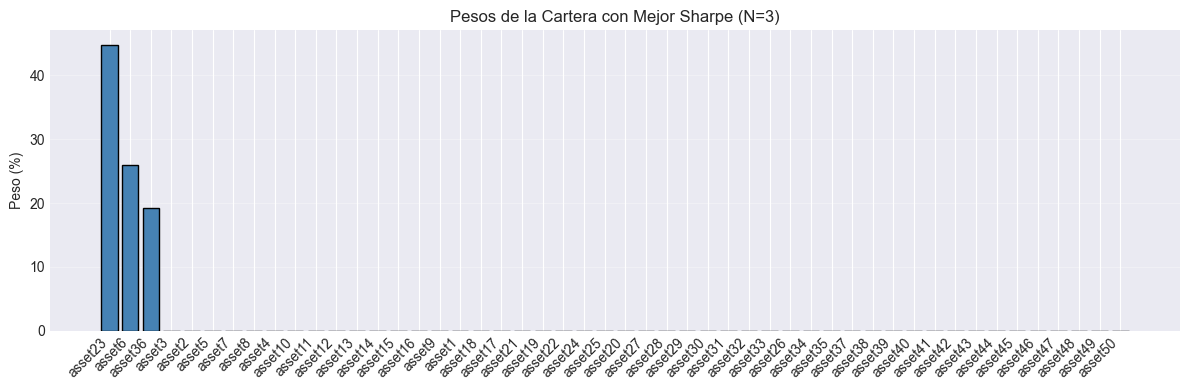

In [13]:
resultado_mejor = resultados[mejor_n]

pesos_completos = resultado_mejor['pesos_completos']
activos_labels = [f'asset{i+1}' for i in range(len(pesos_completos))]

df_pesos_mejor = pd.DataFrame({
    'activo': activos_labels,
    'peso': pesos_completos
}).sort_values('peso', ascending=False).reset_index(drop=True)

print("Activos seleccionados (peso > 0):")
print(df_pesos_mejor[df_pesos_mejor['peso'] > 0].head(20))

print("\nMétricas completas:")
print(resultado_mejor['metricas_cartera'])

print("\nComparación con baseline equiponderado:")
print(resultado_mejor['comparacion_baseline'])

# Gráfico de pesos de la mejor cartera
plt.figure(figsize=(12, 4))
plt.bar(df_pesos_mejor['activo'], df_pesos_mejor['peso'] * 100, color='steelblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Peso (%)')
plt.title(f'Pesos de la Cartera con Mejor Sharpe (N={mejor_n})')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Análisis detallado de otras carteras destacadas

Se comparan las 2-3 carteras con mejor Sharpe después de la mejor.

In [14]:
top_k = 4
mejores = df_consolidado.head(top_k)['n_activos'].astype(int).tolist()
mejores = [n for n in mejores if n != mejor_n][:3]

for n in mejores:
    resultado = resultados[n]
    metricas = resultado['metricas_cartera']
    activos_labels = [f'asset{i+1}' for i in range(len(resultado['pesos_completos']))]
    df_pesos = pd.DataFrame({
        'activo': activos_labels,
        'peso': resultado['pesos_completos']
    }).sort_values('peso', ascending=False)

    print(f"\nCartera N={n}")
    print(f"Sharpe: {metricas['sharpe']:.4f} | Rentabilidad: {metricas['rentabilidad']*100:.2f}% | Volatilidad: {metricas['volatilidad']*100:.2f}%")
    print("Top activos por peso:")
    print(df_pesos.head(10))


Cartera N=5
Sharpe: 1.0462 | Rentabilidad: 12.10% | Volatilidad: 9.66%
Top activos por peso:
     activo      peso
1    asset2  0.308279
7    asset8  0.287539
22  asset23  0.178780
5    asset6  0.117015
35  asset36  0.008386
0    asset1  0.000000
4    asset5  0.000000
6    asset7  0.000000
3    asset4  0.000000
2    asset3  0.000000

Cartera N=6
Sharpe: 0.9219 | Rentabilidad: 11.02% | Volatilidad: 9.78%
Top activos por peso:
     activo      peso
41  asset42  0.320107
1    asset2  0.237427
7    asset8  0.216144
22  asset23  0.098328
5    asset6  0.025597
35  asset36  0.002397
4    asset5  0.000000
0    asset1  0.000000
3    asset4  0.000000
2    asset3  0.000000

Cartera N=7
Sharpe: 0.9213 | Rentabilidad: 11.20% | Volatilidad: 9.99%
Top activos por peso:
     activo      peso
41  asset42  0.269024
12  asset13  0.207179
1    asset2  0.184157
7    asset8  0.169209
22  asset23  0.059713
5    asset6  0.008341
35  asset36  0.002377
4    asset5  0.000000
0    asset1  0.000000
3    asset4  0

## Conclusiones

- El N óptimo según estos resultados es el que maximiza el Sharpe en la tabla consolidada.
- Se observa el trade-off entre diversificación y rendimiento al comparar rentabilidad, volatilidad y Sharpe.
- El peso en renta fija permite verificar si hay una tendencia sistemática entre N y asignación a RF.
- Recomendación: usar la cartera con mejor Sharpe si la reducción de volatilidad no sacrifica demasiado rendimiento.

## Resumen final de carteras (pesos y tablas)

Se muestran los vectores completos de pesos y una tabla de métricas por cartera, ordenadas de mejor a peor según Sharpe.

In [15]:
# Ordenar resultados de mejor a peor Sharpe
ordenados = df_consolidado.copy().reset_index(drop=True)

resumen_filas = []

for _, fila in ordenados.iterrows():
    n = int(fila['n_activos'])
    resultado = resultados.get(n)
    if resultado is None:
        continue

    pesos = resultado['pesos_completos']
    peso_rf = resultado.get('peso_rf', resultado['metricas_cartera'].get('peso_rf', 0.0))

    # Vector completo de pesos (50 posiciones)
    formateador = {"float_kind": lambda x: "0" if abs(x) < 1e-12 else f"{x:.3f}"}
    vector_str = np.array2string(pesos, separator=", ", formatter=formateador)

    print("=" * 80)
    print(f"CARTERA N={n} | SHARPE={fila['sharpe_cartera']:.4f}")
    print("Vector completo de pesos (asset1 a asset50):")
    print(vector_str)
    print(f"Peso en activo libre de riesgo: {peso_rf:.6f}")

    # Tabla de activos con peso > 0
    activos_labels = [f'asset{i+1}' for i in range(len(pesos))]
    df_pesos = pd.DataFrame({
        'activo': activos_labels,
        'peso': pesos,
        'porcentaje': pesos * 100
    })
    df_pesos = df_pesos[df_pesos['peso'] > 0].sort_values('peso', ascending=False)

    print("\nTabla de activos con peso > 0:")
    print(df_pesos.to_string(index=False))

    # Resumen para tabla consolidada
    resumen_filas.append({
        'n_activos': n,
        'sharpe': fila['sharpe_cartera'],
        'rentabilidad': fila['rentabilidad_anual'],
        'volatilidad': fila['volatilidad_anual'],
        'peso_rf': peso_rf,
        'n_activos_con_peso': int((pesos > 0).sum())
    })

# Tabla resumen final de métricas por cartera
print("\n" + "=" * 80)
print("TABLA RESUMEN FINAL (MEJOR A PEOR)")
print("=" * 80)

_df_resumen = pd.DataFrame(resumen_filas)
_df_resumen = _df_resumen.sort_values('sharpe', ascending=False).reset_index(drop=True)
print(_df_resumen.to_string(index=False))

CARTERA N=3 | SHARPE=1.0739
Vector completo de pesos (asset1 a asset50):
[0, 0, 0, 0, 0, 0.260, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0.448, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.192, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0]
Peso en activo libre de riesgo: 0.100000

Tabla de activos con peso > 0:
 activo     peso  porcentaje
asset23 0.448042   44.804214
 asset6 0.259547   25.954737
asset36 0.192410   19.241049
CARTERA N=5 | SHARPE=1.0462
Vector completo de pesos (asset1 a asset50):
[0, 0.308, 0, 0, 0, 0.117, 0, 0.288, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0.179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.008, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0]
Peso en activo libre de riesgo: 0.100000

Tabla de activos con peso > 0:
 activo     peso  porcentaje
 asset2 0.308279   30.827872
 asset8 0.287539   28.753934
asset23 0.178780   17.878016
 asset6 0.117015   11.701550
asset36 0.008386    0.838629
CARTERA N=6 | SHARPE=0.9219
Vector completo de pesos (asset1 a asset50):
[0, 0.2